In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc3 as pm

%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Chapter 04

## Easy

## 4E1

**A:** The first line

## 4E2

**A:** Two, mu and Sigma

## 4E3

$$
Pr(\mu,\sigma)\ =\ \frac{Normal(y|\mu,\sigma,) Normal(\mu|0,10) Uniform(\sigma|0,10)}{\int_{}{}\int_{}{}Normal(y|\mu,\sigma,) Normal(\mu|0,10) Uniform(\sigma|0,10)d\mu d\sigma}
$$

## 4E4

The second line, mu_i = alpha + beta * x_i

## 4E5

**A:** Three: alpha, beta (-> mu) and sigma

## Medium

## 4M1

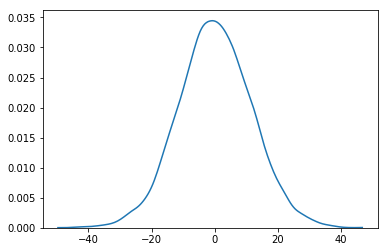

In [5]:
n_samples = int(1e4)
sample_mu = stats.norm.rvs(loc=0, scale=10, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=10, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
pm.kdeplot(prior_h)
plt.show()

## 4M2

In [6]:
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    y = pm.Normal('y', mu=mu, sd=sigma)

In [7]:
with m4_2:
    trace_4_2 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y, sigma_interval__, mu]
100%|██████████| 10500/10500 [00:16<00:00, 623.84it/s]
There were 882 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.714148890330563, but should be close to 0.8. Try to increase the number of tuning steps.
There were 822 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


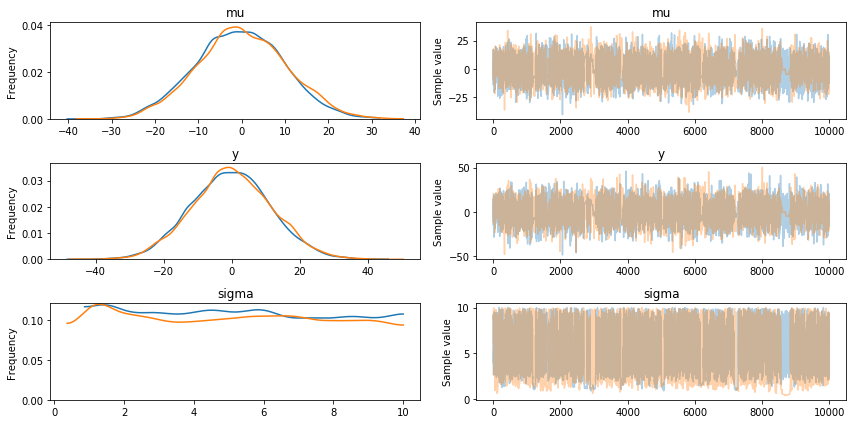

In [8]:
pm.traceplot(trace_4_2);

## 4M3

*too lazy to write all that in laTeX. And this is pretty much as straight forward as it gets.*

## 4M4

$$
h_{i}\ \sim\ Normal(\mu_{i},\sigma)\\
\mu_{i} = \alpha + \beta*t_{i}\\
\alpha\ \sim\ Normal(150, 100)\\
\beta\ \sim\ Normal(0, 10)\\
\sigma\ \sim\ Uniform(0, 10)\\
$$

## 4M5

$$
h_{i}\ \sim\ Normal(\mu_{i},\sigma)\\
\mu_{i} = \alpha + \beta*t_{i}\\
\alpha\ \sim\ Normal(120, 5)\\
\beta\ \sim\ HalfCauchy(0, 10)\\
\sigma\ \sim\ Uniform(0, 10)\\
$$

## 4M6

$$
h_{i}\ \sim\ Normal(\mu_{i},\sigma)\\
\mu_{i} = \alpha + \beta*t_{i}\\
\alpha\ \sim\ Normal(120, 5)\\
\beta\ \sim\ HalfCauchy(0, 10)\\
\sigma\ \sim\ Uniform(0, 64)\\
$$

## Hard

## 4H1

### Load Data

In [2]:
import pandas as pd

d = pd.read_csv('../datasets/Howell1.csv', sep=';', header=0)
d2 = d[d.age >= 18.0]

### Fit Model

In [4]:
import pymc3 as pm

with pm.Model() as m_h_1:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    beta = pm.Normal('beta', mu=0, sd=10)
    alpha = pm.Normal('alpha', mu=156, sd=100)
    mu = alpha + beta * d2.weight
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    
    trace_h_1 = pm.sample()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1071.23draws/s]
The acceptance probability does not match the target. It is 0.8965799875224546, but should be close to 0.8. Try to increase the number of tuning steps.


### Predict Heights

In [12]:
def _rand(r, xs):
    mu = r.alpha + r.beta * xs
    return np.random.normal(mu, r.sigma)
    
def sim(trace: pd.DataFrame, xs, n=1000):
    post = trace[['alpha', 'beta', 'sigma']].sample(n=n, replace=True)
    sim_height_series = post.apply(_rand, 1, xs=xs)
    return np.stack(sim_height_series.values)

In [22]:
import numpy as np

weights = np.array([46.95, 43.72, 64.78, 32.59, 54.63])
trace_df_h_1 = pm.trace_to_dataframe(trace_h_1)

sim_height = sim(trace_df_h_1, weights, n=10_000)

In [23]:
expected_heights = np.apply_along_axis(np.mean, 0, sim_height)

In [24]:
hpd_intervals = np.apply_along_axis(pm.hpd, 0, sim_height, alpha=.11)

### Answer

In [28]:
pd.DataFrame({'weight':weights, 'expected_height': expected_heights, '89% interval lower': hpd_intervals[0], '89% interval upper': hpd_intervals[1]})

,weight,expected_height,89% interval lower,89% interval upper
0,46.95,156.325863,147.492407,164.099302
1,43.72,153.514453,145.536284,161.878791
2,64.78,172.432067,164.142656,180.801252
3,32.59,143.443162,135.029184,151.312903
4,54.63,163.253807,154.742124,171.187549


## 4H2

### Load Data

In [29]:
d3 = d[d.age < 18.0]

In [31]:
len(d3)

192

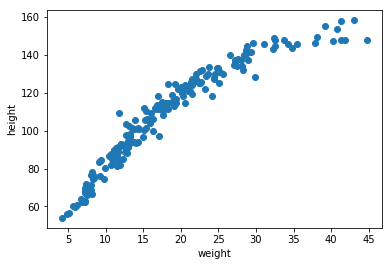

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(d3.weight, d3.height)
plt.xlabel("weight")
plt.ylabel("height");

### Fit Linear Regression

In [45]:
import pymc3 as pm

with pm.Model() as m_h_2:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    beta = pm.Normal('beta', mu=0, sd=10)
    alpha = pm.Normal('alpha', mu=50, sd=50)
    mu = alpha + beta * d3.weight
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d3.height)
    
    trace_h_2 = pm.sample()
    map_h_2 = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2338.22draws/s]
The acceptance probability does not match the target. It is 0.8908556183117652, but should be close to 0.8. Try to increase the number of tuning steps.
logp = -693.92, ||grad|| = 3.0529: 100%|██████████| 35/35 [00:00<00:00, 3070.95it/s]  


In [46]:
map_h_2

{'sigma_interval__': array(-1.59456988),
 'beta': array(2.72024564),
 'alpha': array(58.22648753),
 'sigma': array(8.43709587)}

In [53]:
weight_seq = np.arange(4, 47)
trace_df_h_2 = pm.trace_to_dataframe(trace_h_2)
samples = trace_df_h_2.sample(frac=1)
mu_h_2 = np.zeros((len(weight_seq), len(samples)))
for i,w in enumerate(weight_seq):
    mu_h_2[i] = samples.alpha + samples.beta * w

mu_h_2_hpd = np.apply_along_axis(pm.hpd, 1, mu_h_2, alpha=.11)

In [70]:
sim_height_h_2 = sim(trace_df_h_2, weight_seq, n=10_000)
sim_height_h_2_hpd = np.apply_along_axis(pm.hpd, 0, sim_height_h_2, alpha=.11)
sim_height_h_2_hpd = np.transpose(sim_height_h_2_hpd)

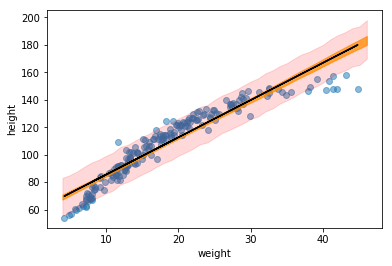

In [77]:
plt.scatter(d3.weight, d3.height, alpha=.5)
regression_line = map_h_2['alpha'] + map_h_2['beta'] * d3.weight
plt.plot(d3.weight, regression_line, color='black')
plt.fill_between(weight_seq, mu_h_2_hpd[:,0],mu_h_2_hpd[:,1], color='orange',alpha=.75)
plt.fill_between(weight_seq, sim_height_h_2_hpd[:,0], sim_height_h_2_hpd[:,1], color='red', alpha=.15)
plt.xlabel("weight")
plt.ylabel("height");

**A:** For every 10 units increase in weight, the expected height seems to rise about 27 centimeters. As we can see from the the MAP regression line plot, the model does a bad job of modelling the weight / height relationship on the at the extreme ends of the weight scale. These ranges of the weights scale represent early childhood as well as beginning adulthood, in which the growth doesn't seem to follow the same terms as during the middle of childhood.

An possible remedy would be to use a poynomial regression in order to fit a curved line to the data.

## 4H3

### Load Data

In [78]:
d = pd.read_csv('../datasets/Howell1.csv', sep=';', header=0)

In [82]:
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


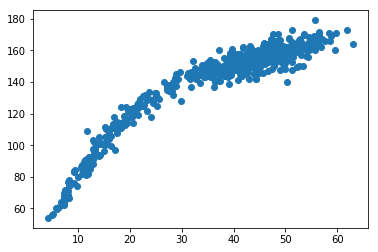

In [80]:
plt.scatter(d.weight, d.height);

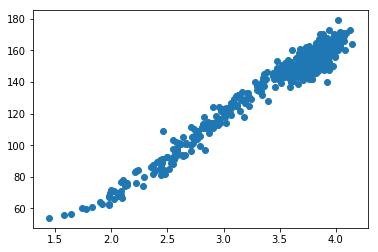

In [81]:
plt.scatter(np.log(d.weight), d.height);

### Feature Engineering

In [83]:
d['weight_log'] = np.log(d.weight)

### Fit Model

In [84]:
import pymc3 as pm

with pm.Model() as m_h_3:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    beta = pm.Normal('beta', mu=0, sd=25)
    alpha = pm.Normal('alpha', mu=0, sd=50)
    mu = alpha + beta * d.weight_log
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    
    trace_h_3 = pm.sample()
    trace_df_h_3 = pm.trace_to_dataframe(trace_h_3)
    map_h_3 = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1226.31draws/s]
The acceptance probability does not match the target. It is 0.9178126696451536, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.927470606880562, but should be close to 0.8. Try to increase the number of tuning steps.
/home/jbrusch/.virtualenvs/jupyter-lab/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2,648.4, ||grad|| = 0.18238: 100%|██████████| 2

In [107]:
weight_log_seq = np.arange(1.4, 4.4, .1)
samples = trace_df_h_3.sample(frac=1)
mu_h_3 = np.zeros((len(weight_log_seq), len(samples)))
for i,w in enumerate(weight_log_seq):
    mu_h_3[i] = samples.alpha + samples.beta * w

mu_h_3_hpd = np.apply_along_axis(pm.hpd, 1, mu_h_3, alpha=.03)

In [108]:
sim_height_h_3 = sim(trace_df_h_3, weight_log_seq, n=10_000)
sim_height_h_3_hpd = np.apply_along_axis(pm.hpd, 0, sim_height_h_3, alpha=.03)
sim_height_h_3_hpd = np.transpose(sim_height_h_3_hpd)

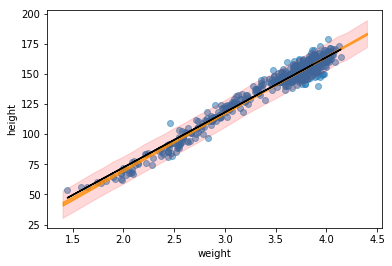

In [109]:
plt.scatter(d.weight_log, d.height, alpha=.5)
regression_line = map_h_3['alpha'] + map_h_3['beta'] * d.weight_log
plt.plot(d.weight_log, regression_line, color='black')
plt.fill_between(weight_log_seq, mu_h_3_hpd[:,0],mu_h_3_hpd[:,1], color='orange',alpha=.75)
plt.fill_between(weight_log_seq, sim_height_h_3_hpd[:,0], sim_height_h_3_hpd[:,1], color='red', alpha=.15)
plt.xlabel("weight")
plt.ylabel("height");